In [50]:
from pprint import pp

In [51]:
# Residual plots
IS_PLOT_RES = False
SAVE_PLOT_RES = False

# Combined plots
SAVE_PLOT = False

# Data
SAVE_DATA = False

### Class definitions
Note that in real production you should put this definition in a separate .py file and import it. 
For example

```python
from classes_v1 import DataHandler, MyUtil, RegSwitcher
```

In [52]:
import pickle
from datetime import datetime
from sklearn.base import BaseEstimator
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import (
    PredictionErrorDisplay,
    mean_absolute_percentage_error,
    mean_squared_error,
    r2_score,
)
import pandas as pd


class MyUtil:
    @staticmethod
    def save_data(filename, data):
        with open(filename, "wb") as file:
            pickle.dump(data, file)
    
    @staticmethod
    def load_data(filename):
        with open(filename, "rb") as file:
            data = pickle.load(file)
        return data

    @staticmethod
    def get_dt():
        return datetime.now().strftime("%Y-%m-%d_%H-%M")


class DataHandler:
    def __init__(self, _X, _Y, scalerX, scalerY):
        self._X = _X
        self._Y = _Y
        self.scalerX = scalerX
        self.scalerY = scalerY
        self.X_train = None
        self.X_test = None
        self.Y_train = None
        self.Y_test = None

    def split_and_scale(self, test_size, random_state):
        _X_train, _X_test, _Y_train, _Y_test = train_test_split(
            self._X, self._Y, test_size=test_size, random_state=random_state
        )
        self.X_train = self.scalerX.fit_transform(_X_train)
        self.X_test = self.scalerX.transform(_X_test)

        self.Y_train = self.scalerY.fit_transform(_Y_train)
        self.Y_test = self.scalerY.transform(_Y_test)

    def get_train(self):
        return self.X_train, self.Y_train

    def get_test(self):
        return self.X_test, self.Y_test


class RegSwitcher(BaseEstimator):
    def __init__(self, base=None):
        self.base = base
        self.dt = datetime.now().strftime("%Y-%m-%d_%H-%M")

    def fit(self, X, Y):
        self.base.fit(X, Y)
        self.is_fitted_ = True
        return self

    def predict(self, X):
        return self.base.predict(X)


class MyEval:
    @staticmethod
    def eval_perf(y_true, y_pred):
        mse = mean_squared_error(y_true=y_true, y_pred=y_pred)
        mape = mean_absolute_percentage_error(y_true=y_true, y_pred=y_pred)
        r2 = r2_score(y_true=y_true, y_pred=y_pred)
        return mse, mape, r2

    @staticmethod
    def pp():
        print("no")

    @classmethod
    def eval(cls, Y_train, Y_test, Y_train_pred, Y_test_pred, **kwargs):
        data_arr = []
        for i in range(0, Y_train.shape[1]):
            mse_train, mape_train, r2_train = cls.eval_perf(
                y_true=Y_train[:, i], y_pred=Y_train_pred[:, i]
            )
            mse_test, mape_test, r2_test = cls.eval_perf(
                y_true=Y_test[:, i], y_pred=Y_test_pred[:, i]
            )

            data = {
                **kwargs,
                "Y": f"Y-{i + 1}",
                "MSE Train (No Val)": mse_train,
                "MSE Test": mse_test,
                "MAPE Train (No Val)": mape_train,
                "MAPE Test": mape_test,
                "R2 Train (No Val)": r2_train,
                "R2 Test": r2_test,
            }
            data_arr.append(data)

        mse_train, mape_train, r2_train = cls.eval_perf(
            y_true=Y_train, y_pred=Y_train_pred
        )
        mse_test, mape_test, r2_test = cls.eval_perf(y_true=Y_test, y_pred=Y_test_pred)
        data = {
            **kwargs,
            "Y": "Y-All",
            "MSE Train (No Val)": mse_train,
            "MSE Test": mse_test,
            "MAPE Train (No Val)": mape_train,
            "MAPE Test": mape_test,
            "R2 Train (No Val)": r2_train,
            "R2 Test": r2_test,
        }
        data_arr.append(data)
        df_eval = pd.DataFrame.from_dict(data_arr)
        return df_eval

    @classmethod
    def plot_res(
        cls,
        Y_train,
        Y_test,
        Y_train_pred,
        Y_test_pred,
        dt="",
        save=False,
        show=True,
        file_prefix="",
    ):
        for i in range(0, Y_train.shape[1]):
            fig, axes = plt.subplots(
                nrows=1,
                ncols=2,
                figsize=(10, 5),
                constrained_layout=True,
                sharex=True,
                sharey=True,
            )

            display_train = PredictionErrorDisplay(
                y_true=Y_train[:, i], y_pred=Y_train_pred[:, i]
            )
            display_train.plot(ax=axes[0])
            axes[0].set_title("Train")

            display_train = PredictionErrorDisplay(
                y_true=Y_test[:, i], y_pred=Y_test_pred[:, i]
            )
            display_train.plot(ax=axes[1])
            axes[1].set_title("Test")

            if file_prefix != "":
                fig.suptitle(file_prefix)

            if save:
                if file_prefix == "":
                    raise Exception("Please specify file prefix")

                filename = f"{file_prefix}_{dt}_{i}.png"
                fig.savefig(filename, dpi=300)

            if show:
                plt.show()


### Load data


In [53]:
# Search for pkl files
from os import listdir
from os.path import isfile, join

onlyfiles = [f for f in listdir(".") if (isfile(join(".", f)) and f.endswith("pkl"))]
pp(onlyfiles)

['S04_data_2025-12-11_11-43.pkl', 'S04_data_2025-12-11_11-50.pkl']


In [54]:
filenameInput = "S04_data_2025-12-11_11-50.pkl"
data_load = MyUtil.load_data(filename=filenameInput)

# Print keys
pp([k for k in data_load.keys()])


['desc', 'data_handler', 'param_split', 'param_grid_hyper', 'df_cv']


In [55]:
dt = MyUtil.get_dt()

In [56]:
data_handler = data_load["data_handler"]
df_cv = data_load["df_cv"]

In [57]:
df_cv

,id_split,param_split,id_gs,params,estimator,mean_test_score,std_test_score,rank_test_score,validation_scores
0,0,"{'random_state': 1, 'test_size': 0.3}",0,{'base': MultiOutputRegressor(estimator=Linear...,LinearRegression,-2.372222,3.924420,12,"[0.03817454546829524, 0.7520241037076204, -7.9..."
1,0,"{'random_state': 1, 'test_size': 0.3}",1,{'base': MultiOutputRegressor(estimator=SVR())...,SVR,-0.006503,0.027330,11,"[-0.0022755109373579683, -0.04188876497945082,..."
2,0,"{'random_state': 1, 'test_size': 0.3}",2,{'base': MultiOutputRegressor(estimator=SVR())...,SVR,0.304896,0.003312,10,"[0.302294515805052, 0.3095696294549572, 0.3028..."
3,0,"{'random_state': 1, 'test_size': 0.3}",3,{'base': MultiOutputRegressor(estimator=SVR())...,SVR,0.744229,0.089645,8,"[0.6177065038720949, 0.8144446900525925, 0.800..."
4,0,"{'random_state': 1, 'test_size': 0.3}",4,{'base': MultiOutputRegressor(estimator=Random...,RandomForestRegressor,0.764350,0.060007,7,"[0.727409071354288, 0.8489858773026763, 0.7166..."
5,0,"{'random_state': 1, 'test_size': 0.3}",5,{'base': MultiOutputRegressor(estimator=Random...,RandomForestRegressor,0.768514,0.061607,6,"[0.7200086736179409, 0.8554444350145421, 0.730..."
6,0,"{'random_state': 1, 'test_size': 0.3}",6,{'base': MultiOutputRegressor(estimator=Random...,RandomForestRegressor,0.774353,0.059540,5,"[0.7296649487893099, 0.8585013868885163, 0.734..."
7,0,"{'random_state': 1, 'test_size': 0.3}",7,{'base': MultiOutputRegressor(estimator=Gradie...,GradientBoostingRegressor,0.886578,0.038766,2,"[0.840115195360608, 0.9350100403074105, 0.8846..."
8,0,"{'random_state': 1, 'test_size': 0.3}",8,{'base': MultiOutputRegressor(estimator=Gradie...,GradientBoostingRegressor,0.887639,0.037617,1,"[0.8384171127499425, 0.929726614124711, 0.8947..."
9,0,"{'random_state': 1, 'test_size': 0.3}",9,{'base': MultiOutputRegressor(estimator=Gradie...,GradientBoostingRegressor,0.835257,0.060089,3,"[0.7570577615238671, 0.9031597755268027, 0.845..."


### Calculate test results


In [58]:
# Sort the DataFrame by "rank_test_score"
df_cv = df_cv.sort_values(by="rank_test_score")

# Groups the sorted DataFrame by the columns "id_split" and "estimator".
# For each group (unique combination of split and estimator), selects the first row (which, after sorting, is the one with the best rank_test_score).
# .reset_index() turns the groupby indices back into columns for a clean DataFrame.
df_fit_select = df_cv.groupby(["id_split", "estimator"]).first().reset_index()

display(df_fit_select)

,id_split,estimator,param_split,id_gs,params,mean_test_score,std_test_score,rank_test_score,validation_scores
0,0,GradientBoostingRegressor,"{'random_state': 1, 'test_size': 0.3}",8,{'base': MultiOutputRegressor(estimator=Gradie...,0.887639,0.037617,1,"[0.8384171127499425, 0.929726614124711, 0.8947..."
1,0,LinearRegression,"{'random_state': 1, 'test_size': 0.3}",0,{'base': MultiOutputRegressor(estimator=Linear...,-2.372222,3.924420,12,"[0.03817454546829524, 0.7520241037076204, -7.9..."
2,0,RandomForestRegressor,"{'random_state': 1, 'test_size': 0.3}",6,{'base': MultiOutputRegressor(estimator=Random...,0.774353,0.059540,5,"[0.7296649487893099, 0.8585013868885163, 0.734..."
3,0,SVR,"{'random_state': 1, 'test_size': 0.3}",3,{'base': MultiOutputRegressor(estimator=SVR())...,0.744229,0.089645,8,"[0.6177065038720949, 0.8144446900525925, 0.800..."
4,1,GradientBoostingRegressor,"{'random_state': 2, 'test_size': 0.3}",7,{'base': MultiOutputRegressor(estimator=Gradie...,0.897944,0.028581,1,"[0.8673896421510445, 0.9361378678076159, 0.890..."
5,1,LinearRegression,"{'random_state': 2, 'test_size': 0.3}",0,{'base': MultiOutputRegressor(estimator=Linear...,-1.937197,3.212609,12,"[-0.13937271276392652, 0.7773593755936509, -6...."
6,1,RandomForestRegressor,"{'random_state': 2, 'test_size': 0.3}",6,{'base': MultiOutputRegressor(estimator=Random...,0.746863,0.092770,5,"[0.621559907344939, 0.8431871023519174, 0.7758..."
7,1,SVR,"{'random_state': 2, 'test_size': 0.3}",3,{'base': MultiOutputRegressor(estimator=SVR())...,0.703175,0.050213,8,"[0.7117799983754173, 0.7599177723301004, 0.637..."
8,2,GradientBoostingRegressor,"{'random_state': 3, 'test_size': 0.3}",7,{'base': MultiOutputRegressor(estimator=Gradie...,0.869598,0.045127,1,"[0.8737176759845623, 0.812383881458254, 0.9226..."
9,2,LinearRegression,"{'random_state': 3, 'test_size': 0.3}",0,{'base': MultiOutputRegressor(estimator=Linear...,-6.095766,8.482889,12,"[-0.9474985147529152, 0.714162186142418, -18.0..."


In [59]:
# Initialize blank model (optional)
reg = RegSwitcher(base=None)


df_arr = []
for idx, fit in df_fit_select.iterrows():
    # pp(fit["param_split"])
    # pp(fit["params"])

    param_split = fit["param_split"]
    data_handler.split_and_scale(**param_split)

    X_train, Y_train = data_handler.get_train()
    X_test, Y_test = data_handler.get_test()

    params = fit["params"]
    reg.set_params(**params)

    reg.fit(X_train, Y_train)

    Y_train_pred = reg.predict(X_train)
    Y_test_pred = reg.predict(X_test)

    _df = MyEval.eval(
        Y_train=Y_train,
        Y_train_pred=Y_train_pred,
        Y_test=Y_test,
        Y_test_pred=Y_test_pred,
        id_split=fit["id_split"],
        id_gs=fit["id_gs"],
        estimator=fit["estimator"],
    )
    df_arr.append(_df)

    if IS_PLOT_RES:
        id_split = fit["id_split"]
        estimator = fit["estimator"]
        MyEval.plot_res(
            Y_train=Y_train,
            Y_train_pred=Y_train_pred,
            Y_test=Y_test,
            Y_test_pred=Y_test_pred,
            dt=dt,
            save=SAVE_PLOT_RES,
            file_prefix=f"S05-{estimator}-{id_split}",
        )

df_eval = pd.concat(df_arr).reset_index(drop=True)

In [60]:
df_eval

,id_split,id_gs,estimator,Y,MSE Train (No Val),MSE Test,MAPE Train (No Val),MAPE Test,R2 Train (No Val),R2 Test
0,0,8,GradientBoostingRegressor,Y-1,4.844552e-04,6.185405e-02,0.049205,0.331459,0.999516,0.931019
1,0,8,GradientBoostingRegressor,Y-2,7.471236e-04,5.833459e-02,0.215710,2.242504,0.999253,0.926729
2,0,8,GradientBoostingRegressor,Y-3,6.816775e-04,6.256540e-02,2.043007,1.341165,0.999318,0.901926
3,0,8,GradientBoostingRegressor,Y-All,6.377521e-04,6.091801e-02,0.769307,1.305043,0.999362,0.919891
4,0,0,LinearRegression,Y-1,9.907769e-08,6.684593e-07,0.000673,0.001180,1.000000,0.999999
...,...,...,...,...,...,...,...,...,...,...
75,4,6,RandomForestRegressor,Y-All,2.256881e-02,1.674031e-01,0.739573,0.586229,0.977431,0.865088
76,4,3,SVR,Y-1,4.722636e-02,1.562070e-01,0.244617,0.276066,0.952774,0.858637
77,4,3,SVR,Y-2,5.036760e-02,1.676328e-01,1.046305,0.411059,0.949632,0.862962
78,4,3,SVR,Y-3,5.589967e-02,2.191328e-01,0.578771,0.749893,0.944100,0.843828


### Further data processing

In [61]:
# Merge
# - **After this code runs:**
#   - `df_eval` will have a new column, `validation_scores`, containing values from `df_cv` where the keys match.
#   - All original rows in `df_eval` are preserved.

# - **What it does:**
#   - Sets the value of the `"Y"` column in the `df_cv` DataFrame to `"Y-All"` for all rows.
#   - If the `"Y"` column does not exist, it is created.
df_cv["Y"] = "Y-All"

# - **What it does:**
#   - Defines a list of column names that will be used from `df_cv` when merging with `df_eval`.
#   - These columns are: `id_split`, `id_gs`, `Y`, and `validation_scores`.
colsToMerge = ["id_split", "id_gs", "Y", "validation_scores"]

# - **What it does:**
#   - Merges the `df_eval` DataFrame with a subset of `df_cv` (only the columns in `colsToMerge`).
#   - The merge is performed on the columns `id_split`, `id_gs`, and `Y`.
#   - `how="left"` specifies a left join, meaning all rows from `df_eval` are kept, and matching rows from `df_cv` are added where available.
#   - If there is no match in `df_cv`, the new columns (e.g., `validation_scores`) will have `NaN` values in `df_eval`.
df_eval = df_eval.merge(df_cv[colsToMerge], on=["id_split", "id_gs", "Y"], how="left")

In [62]:
df_eval

,id_split,id_gs,estimator,Y,MSE Train (No Val),MSE Test,MAPE Train (No Val),MAPE Test,R2 Train (No Val),R2 Test,validation_scores
0,0,8,GradientBoostingRegressor,Y-1,4.844552e-04,6.185405e-02,0.049205,0.331459,0.999516,0.931019,NaN
1,0,8,GradientBoostingRegressor,Y-2,7.471236e-04,5.833459e-02,0.215710,2.242504,0.999253,0.926729,NaN
2,0,8,GradientBoostingRegressor,Y-3,6.816775e-04,6.256540e-02,2.043007,1.341165,0.999318,0.901926,NaN
3,0,8,GradientBoostingRegressor,Y-All,6.377521e-04,6.091801e-02,0.769307,1.305043,0.999362,0.919891,"[0.8384171127499425, 0.929726614124711, 0.8947..."
4,0,0,LinearRegression,Y-1,9.907769e-08,6.684593e-07,0.000673,0.001180,1.000000,0.999999,NaN
...,...,...,...,...,...,...,...,...,...,...,...
75,4,6,RandomForestRegressor,Y-All,2.256881e-02,1.674031e-01,0.739573,0.586229,0.977431,0.865088,"[0.7152823978013628, 0.7421882891309598, 0.750..."
76,4,3,SVR,Y-1,4.722636e-02,1.562070e-01,0.244617,0.276066,0.952774,0.858637,NaN
77,4,3,SVR,Y-2,5.036760e-02,1.676328e-01,1.046305,0.411059,0.949632,0.862962,NaN
78,4,3,SVR,Y-3,5.589967e-02,2.191328e-01,0.578771,0.749893,0.944100,0.843828,NaN


In [63]:
import numpy as np


# - **What this function does:**
#   - Takes a DataFrame `_df` (expected to be a group from a groupby operation).
#   - Extracts the `"validation_scores"` column, which contains arrays or lists.
#   - Concatenates all arrays/lists into a single NumPy array (`val_scores`).
#   - Returns a new DataFrame with one column, `"cv_results"`, containing all the concatenated scores.
def expandCV(_df):
    val_scores = np.concatenate(_df["validation_scores"].values)
    return pd.DataFrame(data={"cv_results": val_scores})


#   - Creates a boolean mask that is `True` where the `"Y"` column equals `"Y-All"`.
#   - This mask is used to filter the DataFrame for relevant rows.
filt = df_eval["Y"] == "Y-All"

# - **Step-by-step:**
#   1. **Filter Rows:**
#      `df_eval[filt]` selects only rows where `"Y" == "Y-All"`.
#   2. **Group by Estimator:**
#      `.groupby(by=["estimator"])` groups the filtered DataFrame by the `"estimator"` column.
#   3. **Apply `expandCV`:**
#      `.apply(expandCV, include_groups=False)` applies the `expandCV` function to each group, expanding the cross-validation results into individual rows.
#   4. **Reset Index:**
#      `.reset_index(drop=False)` resets the index so that group labels become columns.
#   5. **Drop Extra Column:**
#      `.drop(columns=["level_1"])` removes the `"level_1"` column, which is a byproduct of the groupby-apply process.
cv_data = (
    df_eval[filt]
    .groupby(by=["estimator"])
    .apply(expandCV)
    .reset_index(drop=False)
    .drop(columns=["level_1"])
)

display(cv_data)

,estimator,cv_results
0,GradientBoostingRegressor,0.838417
1,GradientBoostingRegressor,0.929727
2,GradientBoostingRegressor,0.894772
3,GradientBoostingRegressor,0.867390
4,GradientBoostingRegressor,0.936138
5,GradientBoostingRegressor,0.890306
6,GradientBoostingRegressor,0.873718
7,GradientBoostingRegressor,0.812384
8,GradientBoostingRegressor,0.922692
9,GradientBoostingRegressor,0.882501


### Plotting

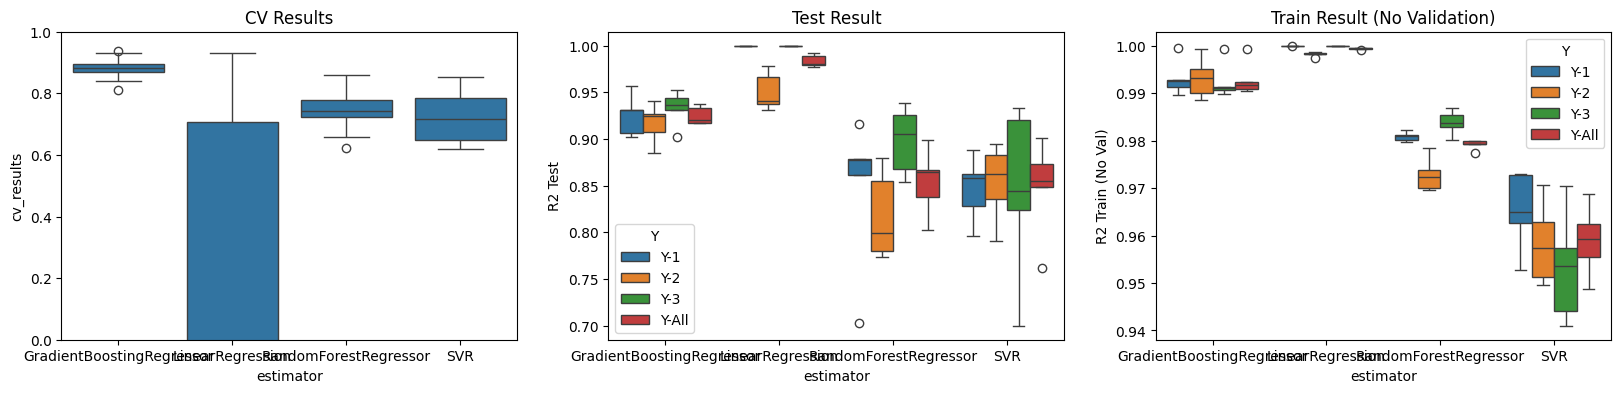

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 3, figsize=(20, 4))

# Plot CV results
sns.boxplot(cv_data, x="estimator", y="cv_results", ax=axes[0])
axes[0].set_ylim([0, 1])
axes[0].set_title("CV Results")

# Plot test results
ax = sns.boxplot(data=df_eval, x="estimator", y="R2 Test", hue="Y", ax=axes[1])
axes[1].set_title("Test Result")

# Plot train (no cv) results
sns.boxplot(data=df_eval, x="estimator", y="R2 Train (No Val)", hue="Y", ax=axes[2])
axes[2].set_title("Train Result (No Validation)")

if SAVE_PLOT:
    filename = f"S05_eval_{dt}.png"
    fig.savefig(filename, dpi=300, bbox_inches="tight")

### Save data

In [65]:
if SAVE_DATA:
    filename = f"S05_data_{dt}.pkl"

    data_save = {
        "desc": "This is the saved data",
        "filenameInput": filename,
        "df_eval": df_eval,
        "cv_data": cv_data,
    }

    # Save the model
    MyUtil.save_data(filename=filename, data=data_save)

### Test loading data


In [66]:
if SAVE_DATA:
    data_load = MyUtil.load_data(filename=filename)

    pp(list(data_load.keys()))